In [1]:
import tensorflow as tf
import os
tf.__version__

'2.8.0'

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
file_path='/content/drive/MyDrive/dt_2'
train_path='/content/drive/MyDrive/dt_2/train'
train_normal_path='/content/drive/MyDrive/dt_2/train/Normal'
train_osteoporosis_path='/content/drive/MyDrive/dt_2/train/Osteoporosis'
validation_path='/content/drive/MyDrive/dt_2/val'
validation_normal_path='/content/drive/MyDrive/dt_2/val/Normal'
validation_osteoporosis_path='/content/drive/MyDrive/dt_2/val/Osteoporosis'
test_path='/content/drive/MyDrive/dt_2/test'
test_normal_path='/content/drive/MyDrive/dt_2/test/Normal'
test_osteoporosis_path='/content/drive/MyDrive/dt_2/test/Osteoporosis'

In [4]:
train_images = []
train_labels = [] 

In [5]:
import numpy as np 
import matplotlib.pyplot as plt
import glob
import cv2
for directory_path in os.listdir(train_path):
    label = directory_path.split("\\")[-1]
    for img_path in  glob.glob(os.path.join(train_path,directory_path, "*")):
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)    
        img = cv2.resize(img, (224, 224))
        train_images.append(img)
        train_labels.append(label)

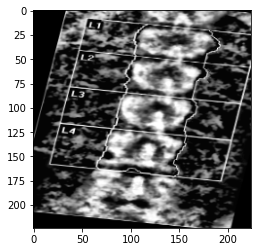

In [6]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
plt.imshow(train_images[0])

In [7]:
train_images = np.array(train_images)
train_labels = np.array(train_labels)

In [8]:
test_images = []
test_labels = [] 

In [9]:
import numpy as np 
import matplotlib.pyplot as plt
import glob
import cv2
for directory_path in os.listdir(test_path):
    label = directory_path.split("\\")[-1]
    for img_path in  glob.glob(os.path.join(test_path,directory_path, "*")):
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)     
        img = cv2.resize(img, (224, 224))
        test_images.append(img)
        test_labels.append(label)

In [10]:
test_images = np.array(test_images)
test_labels = np.array(test_labels)

In [11]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(test_labels)
test_labels_encoded = le.transform(test_labels)
le.fit(train_labels)
train_labels_encoded = le.transform(train_labels)

In [12]:
x_train, y_train, x_test, y_test = train_images, train_labels_encoded, test_images, test_labels_encoded

In [13]:
x_train, x_test = x_train / 255.0, x_test / 255.0

In [14]:
from tensorflow.keras.utils import to_categorical
y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)

In [15]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Flatten, Activation,Input,GlobalAveragePooling2D,Dropout
from tensorflow.keras import Sequential
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.models import Model

In [16]:
IMAGE_SIZE = [224, 224,3]
rn_model = ResNet50(input_shape=IMAGE_SIZE,include_top=False, weights='imagenet')
print(rn_model.summary())

94781440/94765736 [==============================] - 1s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                          

In [17]:
for layer in rn_model.layers:
  layer.trainable=False


In [18]:

model_1 = Sequential()
model_1.add(rn_model)

In [19]:
feature_extractor=model_1.predict(x_train)

features = feature_extractor.reshape(feature_extractor.shape[0], -1)

In [26]:
X_for_RF = features

In [27]:
from sklearn.ensemble import RandomForestClassifier
RF_model = RandomForestClassifier(n_estimators = 100, random_state = 42)

In [28]:
RF_model.fit(X_for_RF, y_train)

RandomForestClassifier(random_state=42)

In [29]:
X_test_feature = model_1.predict(x_test)
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)


In [37]:
prediction_RF = RF_model.predict(X_test_features)
y_pred=prediction_RF

In [38]:
prediction_RF = le.inverse_transform(prediction_RF)

In [39]:

from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(test_labels, prediction_RF))

Accuracy =  0.868020304568528


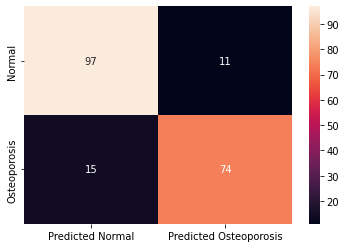

In [56]:
from sklearn.metrics import confusion_matrix,classification_report
import seaborn as sns
import pandas as pd

cm = pd.DataFrame(data=confusion_matrix(test_labels, prediction_RF),index=[ "Normal", "Osteoporosis"],
                  columns=["Predicted Normal", "Predicted Osteoporosis"])
#print(cm)
sns.heatmap(cm, annot=True,fmt="d")

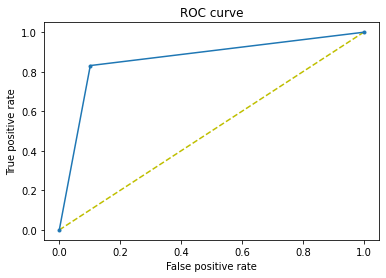

In [49]:
from sklearn.metrics import roc_curve
y_preds = y_pred.ravel()

fpr, tpr, thresholds = roc_curve(y_test, y_preds)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'y--')
plt.plot(fpr, tpr, marker='.')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.show()

In [50]:
from sklearn.metrics import auc
auc_value = auc(fpr, tpr)
print("Area under curve, AUC = ", auc_value)

Area under curve, AUC =  0.8648044111527258


In [52]:
print(classification_report(y_true=y_test,y_pred=y_pred,target_names =['NORMAL','Osteoporosis']))

              precision    recall  f1-score   support

      NORMAL       0.87      0.90      0.88       108
Osteoporosis       0.87      0.83      0.85        89

    accuracy                           0.87       197
   macro avg       0.87      0.86      0.87       197
weighted avg       0.87      0.87      0.87       197

